# <font color=green>ADD-Net: An Effective Deep Learning Model for Early Detection of Alzheimer’s Diseases in MRI Scans</font>

### **<font color=purple> packages that need to install to run this code </font>**
- pip install <font color=red>**tensrflow**</font> || in case of GPU use pip install <font color=red>**tensrflow-gpu**</font>
- pip install <font color=red>**imblearn**</font>
- pip install <font color=red>**tensorflow-addons**</font>
- pip install <font color=red>**matplotlib**</font>
- pip install <font color=red>**seaborn**</font>
- pip install <font color=red>**keras**</font>
- pip install <font color=red>**scikit-learn**</font>

### **Dataset [Link](https://www.kaggle.com/datasets/shahidzikria/alz-dataset)**
#### File modified to run on colab
##### **Follow the below instructions**
- Instructions to add dataset in colab from kaggle [Link](https://www.kaggle.com/general/74235)
- download dataset in your current directory or another and carefully add path in the **WORKING_DIRECTORY** variable

In [36]:

!pip install imblearn
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn
!pip install kagglehub
!pip install torch
!pip install torchsummary


### <font color=orange> Importing Libraries </font>

In [ ]:
import kagglehub

import numpy as np
import random
import pandas as pd

#   Plotting
import seaborn as sns
import matplotlib.pyplot as plt

#   count each class samples
from collections import Counter



#   evaluate precison recall and f1-score of each class of model
from sklearn.metrics import classification_report
#   Show performance of a classification model
from sklearn.metrics import confusion_matrix


# split dataset to train, validation and test set
from sklearn.model_selection import train_test_split



#   SMOTETomek from imblance library
from imblearn.combine import SMOTETomek



from sklearn.metrics import roc_curve, auc
from itertools import cycle

import torch
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import classification_report, confusion_matrix
from imblearn.combine import SMOTETomek
from sklearn.model_selection import train_test_split

### <font color=orange> Define directory of dataset & Classes names </font>

In [3]:
## Set Path Here before running the code

# Download latest version
path = kagglehub.dataset_download("shahidzikria/alz-dataset")

print("Path to dataset files:", path)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
dataset = datasets.ImageFolder(root=path, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

WORKING_DIRECTORY =  path+"/dataset"

##  Name of classes 
CLASSES = ['MildDemented',
           'ModerateDemented',
           'NonDemented',
           'VeryMildDemented']

Path to dataset files: C:\Users\aaron\.cache\kagglehub\datasets\shahidzikria\alz-dataset\versions\1


### <font color=orange> Load Images, Rescale Images, and seperate from data generator & Label One Hot encoding </font>

In [4]:
# Data Preparation
datagen_transform = transforms.Compose([
    transforms.Resize((176, 208)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load Dataset
dataset = datasets.ImageFolder(root=WORKING_DIRECTORY, transform=datagen_transform)
X = torch.stack([img[0] for img in dataset]).numpy()
y = np.array([img[1] for img in dataset])

In [5]:
samples_before = len(X)
print("Images shape :\t", X.shape)
print("Labels shape :\t", y.shape)

Images shape :	 (6400, 3, 176, 208)
Labels shape :	 (6400,)


In [6]:
#   Number of samples in classes 
class_counts = {cls: 0 for cls in dataset.class_to_idx}
for _, label in dataset.samples:
    class_counts[list(dataset.class_to_idx.keys())[label]] += 1

print("Number of samples in each class:\t", class_counts)

#   class labels as per indices
print("Class indices from ImageFolder:", dataset.class_to_idx)


Number of samples in each class:	 {'MildDemented': 896, 'ModerateDemented': 64, 'NonDemented': 3200, 'VeryMildDemented': 2240}
Class indices from ImageFolder: {'MildDemented': 0, 'ModerateDemented': 1, 'NonDemented': 2, 'VeryMildDemented': 3}


### <font color=orange> Show some random samples from the origional dataset </font>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9843137].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9607843].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.78039217].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.92941177].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9843137].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.5058824].
Clipping input data to t

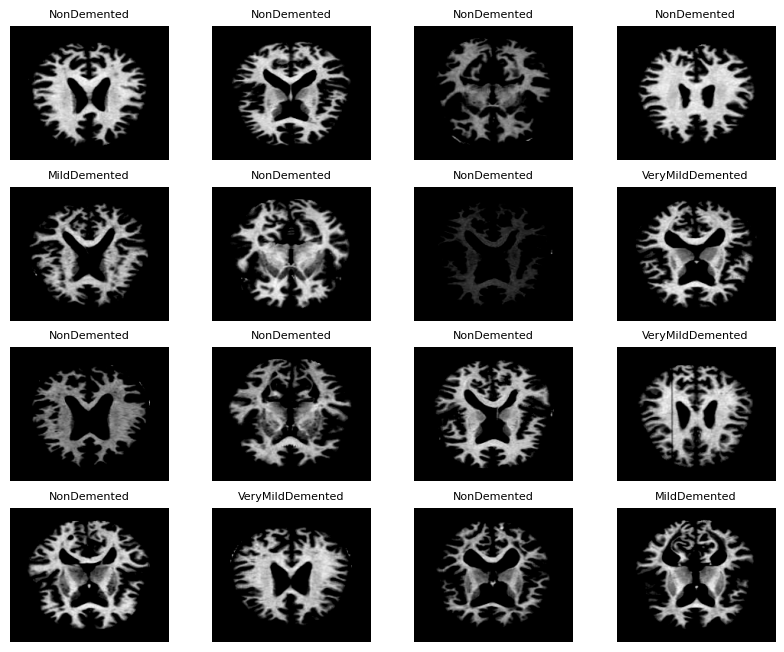

In [7]:
#   show some samples from the dataset randomly

X = torch.tensor(X)  # Convert back to PyTorch tensor if needed

fig = plt.figure(figsize=(10, 8))

rows = 4
columns = 4

for i in range(rows * columns):
    fig.add_subplot(rows, columns, i + 1)
    num = random.randint(0, len(X) - 1)
    
    img = X[num].permute(1, 2, 0).cpu().numpy()  # Now this works since X is a tensor
    
    plt.imshow(img)
    plt.axis('off')
    plt.title(CLASSES[y[num].item()], fontsize=8)
plt.axis('off')
plt.show()



In [8]:
# Convert X back to PyTorch tensor
X = torch.tensor(X).permute(0, 3, 1, 2).float()  # Change shape to [N, C, H, W] for PyTorch
y = torch.tensor(y).long()  # Convert y to tensor with integer labels

# Verify shapes
print(f"X shape: {X.shape}")  # Should be [6400, 3, 176, 208]
print(f"y shape: {y.shape}")  # Should be [6400]


C:\Users\aaron\AppData\Local\Temp\ipykernel_14244\1010801359.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X).permute(0, 3, 1, 2).float()  # Change shape to [N, C, H, W] for PyTorch


X shape: torch.Size([6400, 208, 3, 176])
y shape: torch.Size([6400])


### <font color=orange> Apply SMOTETomek Algorithm to balance the dataset </font>

In [18]:
if isinstance(X, torch.Tensor):
    X = X.numpy()  # Only convert if it's a tensor
print(type(X))


<class 'numpy.ndarray'>


In [ ]:
# SMOTETomek to balance dataset
X = X.reshape(X.shape[0], -1).astype(np.float32)  # Ensure proper shape and dtype
X, y = SMOTETomek().fit_resample(X, y)             # SMOTETomek requires NumPy arrays
X = torch.tensor(X).reshape(-1, 3, 176, 208)       # Convert to PyTorch tensor after SMOTETomek





C:\Users\aaron\AppData\Local\Temp\ipykernel_14244\1935211380.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return DataLoader(TensorDataset(torch.tensor(X, dtype=torch.float32),


### <font color=orange> Splitting dataset for Training, Validation & Testing </font>

In [ ]:
# Split Dataset
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

# Convert to TensorDataset
def to_tensor_dataset(X, y):
    return DataLoader(TensorDataset(torch.tensor(X, dtype=torch.float32),
                                    torch.tensor(y, dtype=torch.long)),
                                    batch_size=8, shuffle=True)

dataloaders = {
    'train': to_tensor_dataset(X_train, y_train),
    'val': to_tensor_dataset(X_val, y_val),
    'test': to_tensor_dataset(X_test, y_test)
}

def format_distribution(label, data):
    formatted_data = " | ".join([f"Class {cls} - {count}" for cls, count in data])
    print(f"{label:<12}: {formatted_data}")

# Display sample distribution
print("\nNumber of samples after splitting into Training, Validation & Test set\n")

format_distribution("Train", sorted(Counter(y_train).items()))
format_distribution("Validation", sorted(Counter(y_val).items()))
format_distribution("Test", sorted(Counter(y_test).items()))



C:\Users\aaron\AppData\Local\Temp\ipykernel_14244\3607315790.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return DataLoader(TensorDataset(torch.tensor(X, dtype=torch.float32),



Number of samples after splitting into Training, Validation & Test set

Train       : Class 0 - 2561 | Class 1 - 2566 | Class 2 - 2563 | Class 3 - 2550
Validation  : Class 0 - 329 | Class 1 - 322 | Class 2 - 296 | Class 3 - 333
Test        : Class 0 - 310 | Class 1 - 312 | Class 2 - 341 | Class 3 - 317


In [26]:
#   to free memeory we don't need this one as we split our data
del X, y

### <font color=orange> Model Architecture </font>

In [37]:
device = torch.device('cuda')  # Force GPU

# Model Definition
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=5)
        self.pool = nn.AvgPool2d(2, 2)
        self.flatten = nn.Flatten()
        
        # Correct fc1 size (identified from error message)
        self.fc1 = nn.Linear(8064, 256)
        
        self.dropout1 = nn.Dropout(0.01)
        self.dropout2 = nn.Dropout(0.03)
        self.fc2 = nn.Linear(256, 4)

    def forward(self, x):
        print(f"Forward Pass Input Shape: {x.shape}")
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.flatten(x)
        print(f"Flattened Shape: {x.shape}")
        x = self.dropout1(F.relu(self.fc1(x)))
        x = self.dropout2(x)
        return self.fc2(x)


model = Model().to(device)

# Optimizer and Loss
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

from torchsummary import summary

model = Model().to(device)
summary(model, (3, 176, 208))  # Just specify the image dimensions, no batch size needed





Forward Pass Input Shape: torch.Size([2, 3, 176, 208])
Flattened Shape: torch.Size([2, 8064])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 172, 204]           1,216
         AvgPool2d-2          [-1, 16, 86, 102]               0
            Conv2d-3           [-1, 32, 82, 98]          12,832
         AvgPool2d-4           [-1, 32, 41, 49]               0
            Conv2d-5           [-1, 64, 37, 45]          51,264
         AvgPool2d-6           [-1, 64, 18, 22]               0
            Conv2d-7          [-1, 128, 14, 18]         204,928
         AvgPool2d-8            [-1, 128, 7, 9]               0
           Flatten-9                 [-1, 8064]               0
           Linear-10                  [-1, 256]       2,064,640
          Dropout-11                  [-1, 256]               0
          Dropout-12                  [-1, 256]               0
         

### <font color=orange> Checks </font>

In [40]:
for inputs, labels in dataloaders['train']:
    inputs = inputs.to(device)  # Correct: Overwrite tensors
    labels = labels.to(device)  # Correct: Overwrite tensors

    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    print(inputs.device, labels.device)  # Should now print 'cuda'


Forward Pass Input Shape: torch.Size([8, 3, 176, 208])
Flattened Shape: torch.Size([8, 8064])
cuda:0 cuda:0
Forward Pass Input Shape: torch.Size([8, 3, 176, 208])
Flattened Shape: torch.Size([8, 8064])
cuda:0 cuda:0
Forward Pass Input Shape: torch.Size([8, 3, 176, 208])
Flattened Shape: torch.Size([8, 8064])
cuda:0 cuda:0
Forward Pass Input Shape: torch.Size([8, 3, 176, 208])
Flattened Shape: torch.Size([8, 8064])
cuda:0 cuda:0
Forward Pass Input Shape: torch.Size([8, 3, 176, 208])
Flattened Shape: torch.Size([8, 8064])
cuda:0 cuda:0
Forward Pass Input Shape: torch.Size([8, 3, 176, 208])
Flattened Shape: torch.Size([8, 8064])
cuda:0 cuda:0
Forward Pass Input Shape: torch.Size([8, 3, 176, 208])
Flattened Shape: torch.Size([8, 8064])
cuda:0 cuda:0
Forward Pass Input Shape: torch.Size([8, 3, 176, 208])
Flattened Shape: torch.Size([8, 8064])
cuda:0 cuda:0
Forward Pass Input Shape: torch.Size([8, 3, 176, 208])
Flattened Shape: torch.Size([8, 8064])
cuda:0 cuda:0
Forward Pass Input Shape: to

In [38]:
print(f"CUDA Available: {torch.cuda.is_available()}")
print(f"Current Device: {torch.cuda.current_device()}")
print(f"Device Name: {torch.cuda.get_device_name(torch.cuda.current_device())}")


CUDA Available: True
Current Device: 0
Device Name: NVIDIA GeForce RTX 3070


In [41]:
for name, param in model.named_parameters():
    if param.grad is None:
        print(f"{name} has no gradient!")


In [42]:
for name, param in model.named_parameters():
    print(f"{name} requires_grad: {param.requires_grad}")


conv1.weight requires_grad: True
conv1.bias requires_grad: True
conv2.weight requires_grad: True
conv2.bias requires_grad: True
conv3.weight requires_grad: True
conv3.bias requires_grad: True
conv4.weight requires_grad: True
conv4.bias requires_grad: True
fc1.weight requires_grad: True
fc1.bias requires_grad: True
fc2.weight requires_grad: True
fc2.bias requires_grad: True


In [46]:
print(f"Train Dataset Size: {len(dataloaders['train'].dataset)}")
for inputs, labels in dataloaders['train']:
    print("✅ DataLoader Iterating - Batch Found!")
    break  # Ensure it's processing batches
from torch.utils.data import TensorDataset, DataLoader

dataloaders['train'] = DataLoader(
    TensorDataset(
        torch.tensor(X_train, dtype=torch.float32),
        torch.tensor(y_train, dtype=torch.long)
    ),
    batch_size=32,
    shuffle=True
)
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(dataset.class_to_idx)

print("Class indices from ImageFolder:", dataset.class_to_idx)


Train Dataset Size: 10240
✅ DataLoader Iterating - Batch Found!


C:\Users\aaron\AppData\Local\Temp\ipykernel_14244\1792044071.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(X_train, dtype=torch.float32),


X_train shape: torch.Size([10240, 3, 176, 208]), y_train shape: (10240,)
{'MildDemented': 0, 'ModerateDemented': 1, 'NonDemented': 2, 'VeryMildDemented': 3}
Class indices from ImageFolder: {'MildDemented': 0, 'ModerateDemented': 1, 'NonDemented': 2, 'VeryMildDemented': 3}


In [47]:
for inputs, labels in dataloaders['train']:
    print(f"Batch Found - Inputs Shape: {inputs.shape}, Labels Shape: {labels.shape}")
    break  # Ensure it prints once
print("Dataset Class Distribution:", {k: v for k, v in Counter(y_train).items()})
print(f"Sample Input Shape: {X_train[0].shape}, Sample Label: {y_train[0]}")
print(model)  # Confirm layers are intact


Batch Found - Inputs Shape: torch.Size([32, 3, 176, 208]), Labels Shape: torch.Size([32])
Dataset Class Distribution: {np.int64(2): 2563, np.int64(3): 2550, np.int64(1): 2566, np.int64(0): 2561}
Sample Input Shape: torch.Size([3, 176, 208]), Sample Label: 2
Model(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=8064, out_features=256, bias=True)
  (dropout1): Dropout(p=0.01, inplace=False)
  (dropout2): Dropout(p=0.03, inplace=False)
  (fc2): Linear(in_features=256, out_features=4, bias=True)
)


### <font color=orange> Defining CALLBACKS to reduce Learning Rate </font>

In [48]:
# callbacks used in model to perform well
# Initialize optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Define scheduler (similar to ReduceLROnPlateau)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                  mode='min', 
                                                  factor=0.1,  # Reduce LR by 10x
                                                  patience=2,  # Same patience setting
                                                  verbose=True)

d:\Anaconda\envs\test\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


### <font color=orange> Training of the Model </font>

In [49]:
import torch.backends.cudnn as cudnn
from torch.cuda.amp import autocast, GradScaler

scaler = GradScaler()  # Enable mixed precision
cudnn.benchmark = True  # Optimize convolution performance

def train(model, dataloaders, optimizer, criterion, epochs=40, accumulation_steps=4):
    model.to(device)
    model.train()
    print('hi')
    
    for epoch in range(epochs):
        print(f"🔄 Entering Training Loop - Epoch {epoch + 1}")
        total_loss = 0.0
        batch_count = 0

        for batch_idx, (inputs, labels) in enumerate(dataloaders['train']):
            print(f"Processing Batch {batch_count + 1}...")

            inputs = inputs.to(device, non_blocking=True)
            labels = labels.to(torch.long).to(device, non_blocking=True)

            optimizer.zero_grad()

            # Mixed Precision Training for Better GPU Efficiency
            with autocast():
                try:
                    outputs = model(inputs)
                    print("✅ Forward Pass Successful")
                except Exception as e:
                    print(f"🚨 Forward Pass Failed: {e}")
                    continue

                loss = criterion(outputs, labels) / accumulation_steps
                print(f"Loss Value: {loss.item()}")

                if torch.isnan(loss) or loss == 0:
                    print("❌ Loss is NaN or Zero!")
                    continue

            scaler.scale(loss).backward()

            if (batch_idx + 1) % accumulation_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            total_loss += loss.item()
            batch_count += 1

        print(f"Epoch {epoch+1}/{epochs}, Avg Loss: {total_loss / batch_count:.4f}")

train(model, dataloaders, optimizer, criterion, epochs=40)


C:\Users\aaron\AppData\Local\Temp\ipykernel_14244\427062577.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # Enable mixed precision
C:\Users\aaron\AppData\Local\Temp\ipykernel_14244\427062577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


hi
🔄 Entering Training Loop - Epoch 1
Processing Batch 1...
Forward Pass Input Shape: torch.Size([32, 3, 176, 208])
Flattened Shape: torch.Size([32, 8064])
✅ Forward Pass Successful
Loss Value: 0.34520721435546875
Processing Batch 2...
Forward Pass Input Shape: torch.Size([32, 3, 176, 208])
Flattened Shape: torch.Size([32, 8064])
✅ Forward Pass Successful
Loss Value: 0.344879150390625
Processing Batch 3...
Forward Pass Input Shape: torch.Size([32, 3, 176, 208])
Flattened Shape: torch.Size([32, 8064])
✅ Forward Pass Successful
Loss Value: 0.348602294921875
Processing Batch 4...
Forward Pass Input Shape: torch.Size([32, 3, 176, 208])
Flattened Shape: torch.Size([32, 8064])
✅ Forward Pass Successful
Loss Value: 0.34627532958984375
Processing Batch 5...
Forward Pass Input Shape: torch.Size([32, 3, 176, 208])
Flattened Shape: torch.Size([32, 8064])
✅ Forward Pass Successful
Loss Value: 0.343902587890625
Processing Batch 6...
Forward Pass Input Shape: torch.Size([32, 3, 176, 208])
Flattened 

### <font color=orange> Evaluation of Model with the Test data </font>

In [53]:
import pandas as pd

# Evaluation Function
def evaluate(model, dataloader):
    model.eval()
    all_labels, all_preds = [], []

    total_samples = 0
    batch_count = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

            total_samples += len(labels)
            batch_count += 1

    # Generate Report
    report = classification_report(all_labels, all_preds, target_names=CLASSES, output_dict=True)
    confusion = confusion_matrix(all_labels, all_preds)

    # Display Results
    print(f"\n✅ Evaluation Complete")
    print(f"Total Samples Processed: {total_samples}")
    print(f"Total Batches Processed: {batch_count}")

    print("\n🔎 Classification Report")
    print(pd.DataFrame(report).transpose().round(4))

    print("\n🟦 Confusion Matrix")
    print(pd.DataFrame(confusion, index=CLASSES, columns=CLASSES))

# Run Evaluation
evaluate(model, dataloaders['test'])


Forward Pass Input Shape: torch.Size([8, 3, 176, 208])
Flattened Shape: torch.Size([8, 8064])
Forward Pass Input Shape: torch.Size([8, 3, 176, 208])
Flattened Shape: torch.Size([8, 8064])
Forward Pass Input Shape: torch.Size([8, 3, 176, 208])
Flattened Shape: torch.Size([8, 8064])
Forward Pass Input Shape: torch.Size([8, 3, 176, 208])
Flattened Shape: torch.Size([8, 8064])
Forward Pass Input Shape: torch.Size([8, 3, 176, 208])
Flattened Shape: torch.Size([8, 8064])
Forward Pass Input Shape: torch.Size([8, 3, 176, 208])
Flattened Shape: torch.Size([8, 8064])
Forward Pass Input Shape: torch.Size([8, 3, 176, 208])
Flattened Shape: torch.Size([8, 8064])
Forward Pass Input Shape: torch.Size([8, 3, 176, 208])
Flattened Shape: torch.Size([8, 8064])
Forward Pass Input Shape: torch.Size([8, 3, 176, 208])
Flattened Shape: torch.Size([8, 8064])
Forward Pass Input Shape: torch.Size([8, 3, 176, 208])
Flattened Shape: torch.Size([8, 8064])
Forward Pass Input Shape: torch.Size([8, 3, 176, 208])
Flatt

In [ ]:
# Save the entire model
torch.save(model.state_dict(), "model_updated.pth")